In [1]:
import pandas as pd
import os
import re
import cv2
from sklearn.cluster import KMeans
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Sample CXR data 


In [ ]:
# load 3 github project
!git clone https://github.com/ieee8023/covid-chestxray-dataset
!git clone https://github.com/agchung/Figure1-COVID-chestxray-dataset
!git clone https://github.com/agchung/Actualmed-COVID-chestxray-dataset

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 27.63 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Checking out files: 100% (1174/1174), done.
Cloning into 'Figure1-COVID-chestxray-dataset'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 112 (delta 28), reused 95 (delta 14), pack-reused 0
Receiving objects: 100% (112/112), 14.13 MiB | 10.93 MiB/s, done.
Resolving deltas: 100% (28/28), done.
Cloning into 'Actualmed-COVID-chestxray-dataset'...
remote: Enumerating objects: 422, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 422 (delta 1), reused 6 (delta 1), pack-reused 412
Receiving objects: 100% (422/422), 1.56 GiB | 27.66 MiB/s, done.
Resolving deltas: 100% 

In [ ]:
# The data source from github ieee8023 covid-chestxray-dataset,Figure1-COVID-chestxray-dataset and Actualmed-COVID-chestxray-dataset
def sample_data_from_gb():

  # Sample data from ieee8023 covid-chestxray-dataset

  data1_csv = pd.read_csv("covid-chestxray-dataset/metadata.csv",nrows=None)

  #Only CXR images were retained and cases with unlabeled diseases were deleted
  data1 = data1_csv[ (data1_csv['modality']== 'X-ray') 
  & (data1_csv['finding'] != 'todo') & (data1_csv['finding'] != 'Unknown') & (data1_csv['finding'] != 'Tuberculosis')
  & ((data1_csv['view'] == 'PA')|(data1_csv['view'] == 'AP'))]

  #Select useful attributes
  data1 = data1.loc[:,['sex','age','finding','location','filename']]

  #Modify the finding and location
  dict={'Pneumonia/Viral/COVID-19':'COVID-19','No Finding':'Normal'}

  for i in range(len(data1)):

    s = data1.iloc[i,2]
    if s in dict:
      data1.iloc[i,2] = dict[s]
    else:
      data1.iloc[i,2] = 'Pneumonia'
    
    #only save country information
    if pd.isnull(data1.iloc[i,3]) == False:
      data1.iloc[i,3] = data1.iloc[i,3].split(',')[-1]

  data_image1 = []
  #Loading pictures ieee8023 covid-chestxray-dataset
  url1= 'covid-chestxray-dataset/images'
  for n in data1['filename']:
    img_url = os.path.join(url1,n)
    #Save only the image as gray
    img = cv2.imread(img_url)
    #The converted image is 224*224 pixels
    img=cv2.resize(img,(224,224))
    data_image1.append(img)
  
  #--------------------------------------------------
  
  # Sample data from Figure1-COVID-chestxray-dataset

  data2_csv = pd.read_csv("Figure1-COVID-chestxray-dataset/metadata.csv",encoding='ISO-8859-1',nrows=None)
  #Deletes a value with an empty label
  data2 = data2_csv [pd.isnull(data2_csv['finding'])==False]

  data2 = data2.loc[:,['sex','age','finding','patientid']]

  for i in range(len(data2)):
    if data2.iloc[i,2] == 'No finding':
      data2.iloc[i,2] = 'Normal'

  #Modify the column name and add a new column
  data2 = data2.reindex(columns=['sex','age','finding','location','patientid'])
  data2.columns = ['sex','age','finding','location','filename']

  #Remove the other characters in age and change the data type
  data2['age'] = data2['age'].str.extract('(\d+)', expand=False)
  data2[['age']]= data2[['age']].values.astype(float)

  data_image2 = []
  #Loading pictures Figure1-COVID-chestxray-dataset
  url2= 'Figure1-COVID-chestxray-dataset/images'
  for n in data2['filename']:
    #The image contains both JPG and PNG. 
    #Catch an exception that does not recognize JPG it will be png
    n1 = n+'.jpg'
    img_url = os.path.join(url2,n1)
    #Save only the image as gray
    img=cv2.imread(img_url)
    if img is None:
      n2 = n+'.png'
      img_url = os.path.join(url2,n2)
      #Save only the image as gray
      img=cv2.imread(img_url)

    #The converted image is 224*224 pixels
    img = cv2.resize(img,(224,224))
    #Normalized picture
    data_image2.append(img)

  #--------------------------------------------------
  
  # Sample data from Actualmed-COVID-chestxray-dataset

  data3_csv = pd.read_csv("Actualmed-COVID-chestxray-dataset/metadata.csv",nrows=None)

  #Deletes a value with an empty label
  data3 = data3_csv [pd.isnull(data3_csv['finding'])==False]

  data3 = data3.loc[:,['sex','age','finding','imagename']]

  for i in range(len(data3)):
      if data3.iloc[i,2] == 'No finding':
        data3.iloc[i,2] = 'Normal'

  #Modify the column name and add a new column
  data3 = data3.reindex(columns=['sex','age','finding','location','imagename'])
  data3.columns = ['sex','age','finding','location','filename']

  data_image3 = []
  #Loading pictures ieee8023 covid-chestxray-dataset
  url3= 'Actualmed-COVID-chestxray-dataset/images'
  for n in data3['filename']:
    img_url = os.path.join(url3,n)
    #Save only the image as gray
    img = cv2.imread(img_url)
    #The converted image is 224*224 pixels
    img=cv2.resize(img, (224,224))
    #Normalized picture
    data_image3.append(img)
  
  #----------------------------------------------------

  #Merge three data sets
  data = pd.concat([data1,data2,data3])
  data = data.reset_index(drop=True)

  data_image = data_image1 + data_image2 + data_image3
  
  return data, data_image


In [ ]:
#Sampling data from Google Drive
def sample_data_from_gd():
  data_csv = pd.read_csv('/content/drive/MyDrive/CheXpert-v1.0-small/train.csv')
  
  #only sampled the first 2,000 patients
  data = data_csv.loc[:8063,:]

  #Filtering useless information
  data = data[ ((data['No Finding']==1) | (data['Pneumonia']==1)) & ((data['AP/PA'] == 'AP') | (data['AP/PA'] == 'PA')) ]
  #Adding label
  data['finding'] = data.apply(lambda x: 'Pneumonia' if x.Pneumonia == 1 else 'Normal', axis=1)
  #Add location
  data['location'] = data.apply(lambda x: 'United States',axis=1)

  #Extract the column and modify the column name
  data = data.loc[:,['Sex','Age','finding','location','Path']]
  data.columns = ['sex','age','finding','location','filename']

  #Replace gender string
  data['sex'] = data['sex'].replace('Female','F')
  data['sex'] = data['sex'].replace('Male','M')

  data_image = []
  url= '/content/drive/MyDrive'
  for n in data['filename']:
    img_url = os.path.join(url,n)
    #Save only the image as gray
    img = cv2.imread(img_url)
    #The converted image is 224*224 pixels
    img=cv2.resize(img,(224,224))
    data_image.append(img)
  
  return data, data_image

In [ ]:
#Xary was sampled and the data was preprocessed
def sample_xray():
  data1,data_image1 = sample_data_from_gb()
  data2,data_image2 = sample_data_from_gd()

  data = pd.concat([data1,data2])
  data = data.reset_index(drop=True)

  data.loc[data['location'].isna(), 'location'] = 'Unknown'
  data['location'] = [location.strip() for location in data['location']]

  data_image = data_image1 + data_image2
  data_image = np.array(data_image)
  
  return data, data_image

2. Sample CT data

In [ ]:
def sample_ct():
  ct = pd.read_csv('/content/drive/MyDrive/COVIDx_CT/metadata.csv')
  ct = ct.iloc[:,:6]

  #Extract the data of the three labels respectively
  ct_sample1 = ct[(ct['finding'] == 'COVID-19') & (ct['source'] != 'MosMedData')]
  ct_sample2 = ct[ct['finding'] == 'Normal']
  ct_sample3 = ct[ct['finding'] == 'Pneumonia']
  #511 data were randomly sampled
  ct_sample1 = ct_sample1.sample(n=511,random_state=42)
  ct_sample2 = ct_sample2.sample(n=511,random_state=42)
  ct_sample3 = ct_sample3.sample(n=511,random_state=42)

  data = pd.concat([ct_sample1,ct_sample2,ct_sample3])
  data = data.reset_index(drop=True)
  data['filename'] = ''
  
  #
  img_name1 = pd.read_csv('/content/drive/MyDrive/COVIDx_CT/test_COVIDx_CT-2A.txt',header = None, sep=' ')
  img_name2 = pd.read_csv('/content/drive/MyDrive/COVIDx_CT/train_COVIDx_CT-2A.txt',header = None, sep=' ')
  img_name3 = pd.read_csv('/content/drive/MyDrive/COVIDx_CT/val_COVIDx_CT-2A.txt',header = None, sep=' ')

  img_name = pd.concat([img_name1[[0]],img_name2[[0]],img_name3[[0]]])
  img_name = img_name.reset_index(drop=True)

  for i in range(len(data)):

    if data.iloc[i,1] == 'COVID-CTSet':
      regex1 = re.compile(r'.*_'+data.iloc[i,0]+'_.*')
      name = []
    
      for j in img_name[0]:
        if regex1.match(j):
          name.append(j)
      index = round(len(name)/2)
      data.iloc[i,6] = name[index]    
          

    elif (data.iloc[i,1] == 'CNCB') | (data.iloc[i,1] == 'COVID-19-20 Challenge') :
      regex2 = re.compile(r''+data.iloc[i,0]+'_.*')
      name = []

      for j in img_name[0]:
        if regex2.match(j):
          name.append(j)
      index = round(len(name)/2)
      data.iloc[i,6] = name[index]
          

    else:
      regex3 = re.compile(r''+data.iloc[i,0]+'-.*')

      for j in img_name[0]:
        if regex3.match(j):
          data.iloc[i,6] = j
          break
    
  data.iloc[275,6] = 'radiopaedia_4_85506_1-0019.png'
  data.iloc[0,6] = 'radiopaedia_40_86625_0-0033.png'  
  
  data_image = []
  url= '/content/drive/MyDrive/sample_CT_v2'
  for n in data['filename']:
    img_url = os.path.join(url,n)
    #Save only the image as gray
    img = cv2.imread(img_url)
    #The converted image is 224*224 pixels
    print(img_url)
    img=cv2.resize(img,(224,224))
    data_image.append(img)
  
  data_image = np.array(data_image)

  return data, data_image



3. Data analysis and preprocessing

In [ ]:
CXR_label,CXR_image = sample_xray()

In [ ]:
#CXR_label,CXR_image = sample_xray()

CXR_label.to_csv('/content/drive/MyDrive/5703-data-sample/new/CXR_label.csv')
np.savez('/content/drive/MyDrive/5703-data-sample/new/CXR_image',arr=CXR_image)


In [ ]:
img = np.load(file='/content/drive/MyDrive/5703-data-sample/CXR_image.npz')
data = pd.read_csv('/content/drive/MyDrive/5703-data-sample/CXR_label.csv') 

In [ ]:
img = img['arr']

In [ ]:
b = []
c = []
for i in range(len(img)):
  if data['finding'][i] == 'Normal':
    b.append(img[i])
    c.append(data['location'][i])

b = np.array(b)

In [ ]:
a = b.reshape(len(b),224*224) 
kmeans = KMeans(n_clusters=2).fit(a)
d = kmeans.labels_

In [ ]:
df = pd.DataFrame(d,columns=['cluster'])
df['location'] = c

In [ ]:
df[df['cluster'] == 1].value_counts()

In [ ]:
CXR_label[CXR_label['finding'] == 'Normal']['kmeans.labels'].value_counts().plot(kind='barh')

In [ ]:
CXR_label[CXR_label['finding'] == 'COVID-19']['kmeans.labels'].value_counts().plot(kind='barh')

In [ ]:
CXR_label[CXR_label['finding'] == 'Pneumonia']['kmeans.labels'].value_counts().plot(kind='barh')

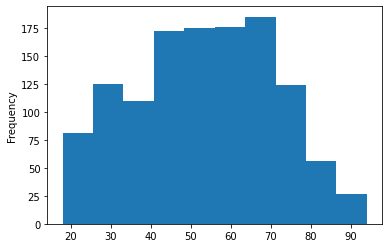

In [ ]:
CXR_label['age'].plot.hist()

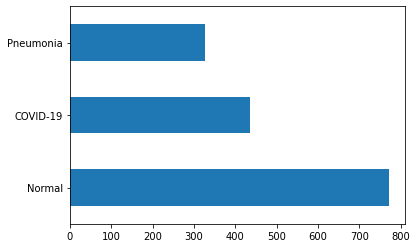

In [ ]:
CXR_label['finding'].value_counts().plot(kind='barh')

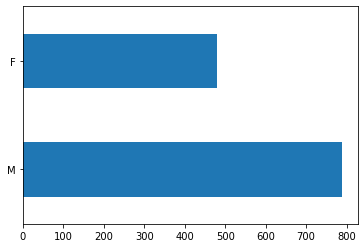

In [ ]:
CXR_label['sex'].value_counts().plot(kind='barh')

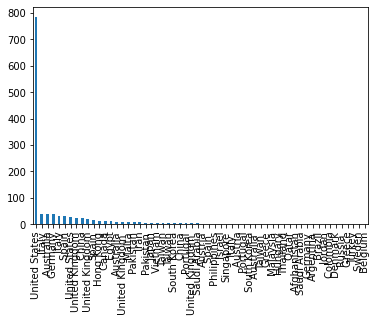

In [ ]:
CXR_label['location'].value_counts().plot(kind='bar')

In [ ]:
CT_label,CT_image = sample_ct()
CT_label.to_csv('/content/drive/MyDrive/5703-data-sample/CT_label.csv')
np.savez('/content/drive/MyDrive/5703-data-sample/CT_image_data',arr1=CT_image)


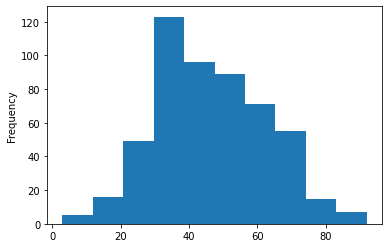

In [ ]:
CT_label['age'].plot.hist()

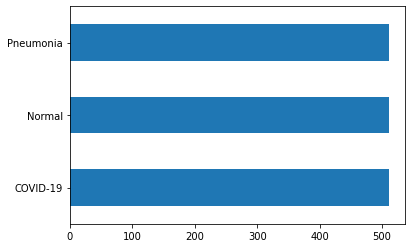

In [ ]:
CT_label['finding'].value_counts().plot(kind='barh')

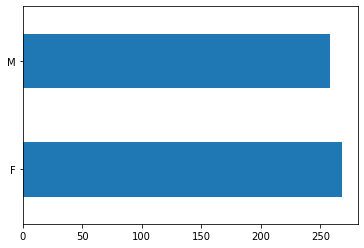

In [ ]:
CT_label['sex'].value_counts().plot(kind='barh')

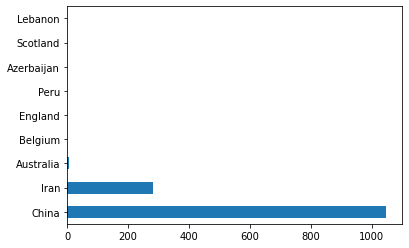

In [ ]:
CT_label['country'].value_counts().plot(kind='barh')

In [ ]:
### directly download the data files from zc's drive
# ! pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import numpy as np
import pandas as pd

# file_id = '15JHdWciQIqY-pajVg0O7tc4o6UQp2erc'
file_id = "1TdK087dkFUA6X1yMySX8tRYNM5CS_Rte"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CT_image_data.npz')
ct_img = np.load(file='CT_image_data.npz')


file_id = '1ViU_heTjGlWFADYNiqWmV_QEx3Ssxzks'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CT_label.csv')
ct_label = pd.read_csv('CT_label.csv') 

# img_3d = ct_img["arr1"]
img_3d = ct_img["arr"]
print(img_3d.shape)
img_2d = img_3d.reshape(1533,224*224)
print(img_2d.shape)

# file_id = '1mpgVvoDUsgxGBhZHM6R4gGvnNFdQVaUJ'
# downloaded = drive.CreateFile({'id': file_id})
# downloaded.GetContentFile('CT_label_train.csv')
# ct_label = pd.read_csv('CT_label.csv') 


# file_id = '1nSpa5GXoGkYJqxiz_NkD6AWp4MUUDEkd'
# downloaded = drive.CreateFile({'id': file_id})
# downloaded.GetContentFile('CT_label_test.csv')
# ct_label = pd.read_csv('CT_label.csv') 

(1533, 224, 224)
(1533, 50176)


In [ ]:
### ct: country; cxr: location
### 1. country & location replace na with unknown
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
Xpca = pca.fit_transform(img_2d)
print(Xpca.shape)
# Xpca.head()

Xtsne = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(Xpca)
print(Xtsne.shape)

df = pd.DataFrame(Xtsne, columns=["x1", "x2"])
df["country"] = ct_label["country"]
df["label"] = ct_label["finding"]
# df.loc[df["country"].isna(), "country"] = "Unknown"
print(df.head(10))

covid = df[df["label"]=="COVID-19"]
covid.head()
normal = df[df["label"]=="Normal"]
normal.head()
pneu = df[df["label"]=="Pneumonia"]
pneu.head()

(1533, 2)
(1533, 2)


In [ ]:
# ct_label.head()
df = pd.DataFrame(Xtsne, columns=["x1", "x2"])
df["country"] = ct_label["country"]
df["label"] = ct_label["finding"]
# df.loc[df["country"].isna(), "country"] = "Unknown"
print(df.head(10))

# df = pd.DataFrame(Xtsne, columns=["x1", "x2"])
# df["country"] = ct_label["country"]
# df["label"] = ct_label["finding"]
# df = df.loc[-df["country"].isna(), ]
# # print(df.sh)
# print(df.head(10))




# df = pd.DataFrame(Xpca, columns=["x1", "x2"])
# df["country"] = ct_label["country"]
# df["label"] = ct_label["finding"]
# df.loc[df["country"].isna(), "country"] = "Unknown"
# df.head(10)

# df = pd.DataFrame(Xpca, columns=["x1", "x2"])
# df["country"] = ct_label["country"]
# df["label"] = ct_label["finding"]
# df = df.loc[-df["country"].isna(), ]
# # print(df.sh)
# print(df.head(10))


covid = df[df["label"]=="COVID-19"]
covid.head()
normal = df[df["label"]=="Normal"]
normal.head()
pneu = df[df["label"]=="Pneumonia"]
pneu.head()

          x1         x2  country     label
0 -14.477036 -18.838039  Belgium  COVID-19
1  13.105991  -7.955327    China  COVID-19
2  25.138281   1.384623    China  COVID-19
3   6.649092  12.214340  Unknown  COVID-19
4  30.652336  21.732420    China  COVID-19
5  -9.105164   8.853215    China  COVID-19
6  13.192981   6.154388    China  COVID-19
7  18.821478 -21.910568  Unknown  COVID-19
8 -10.559743  37.163921    China  COVID-19
9 -15.416965 -28.645451    China  COVID-19


,x1,x2,country,label
1022,32.191799,2.846238,China,Pneumonia
1023,33.065662,-16.096500,China,Pneumonia
1024,-7.993955,28.530882,China,Pneumonia
1025,2.272630,-43.340149,China,Pneumonia
1026,11.495098,5.398749,China,Pneumonia


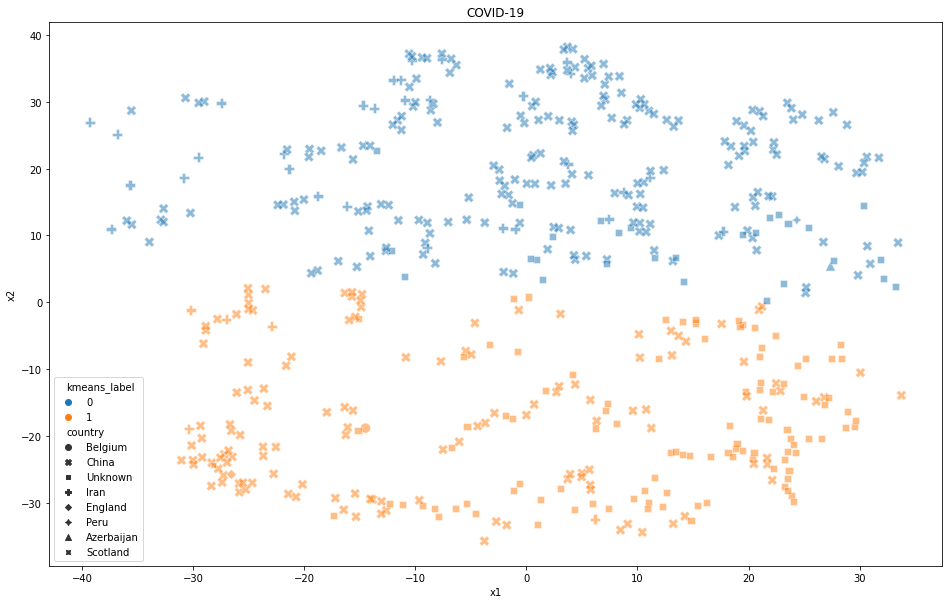

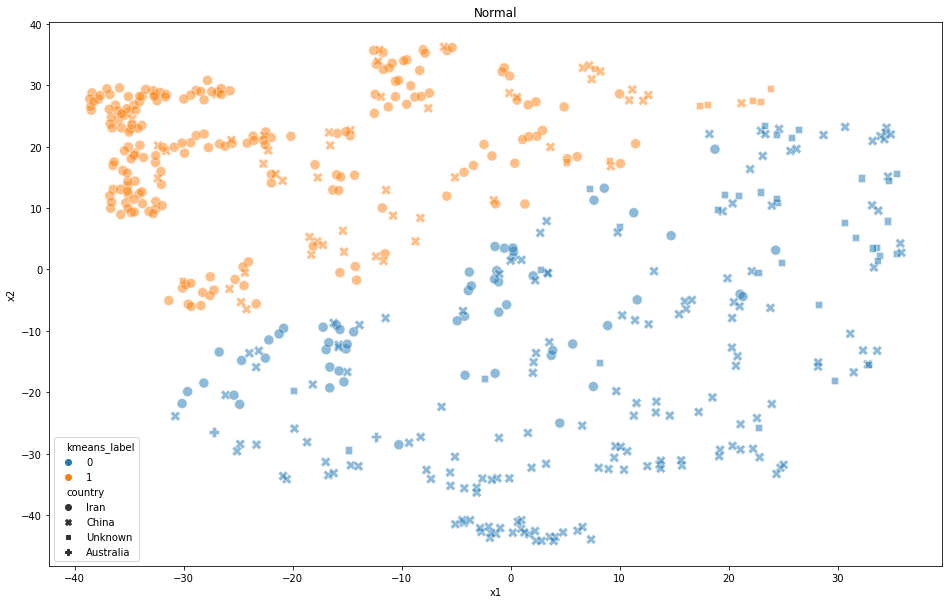

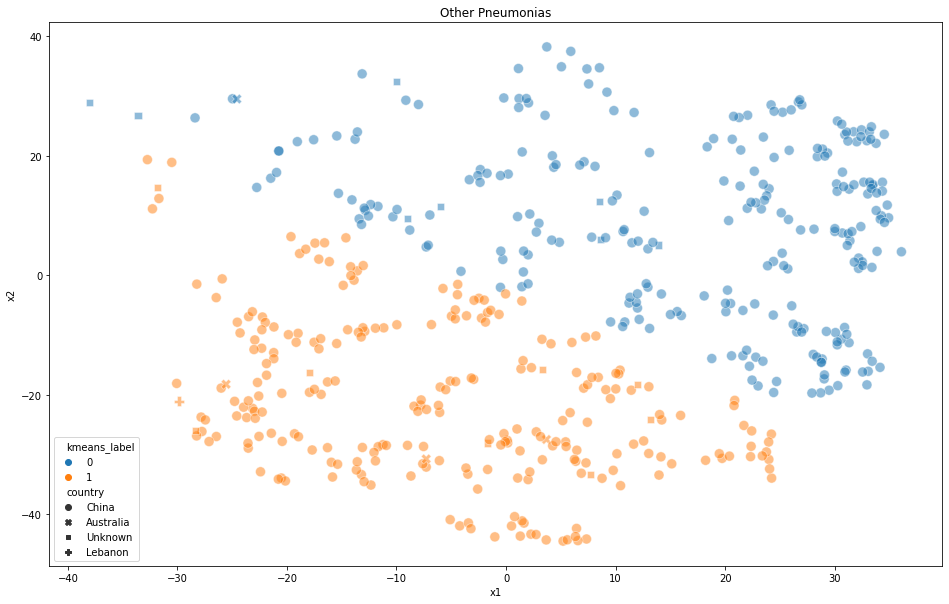

In [ ]:
from sklearn.cluster import KMeans

import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

kmeans_covid = KMeans(n_clusters=2, random_state=42).fit(covid[["x1", "x2"]])
kmeans_normal = KMeans(n_clusters=2, random_state=42).fit(normal[["x1", "x2"]])
kmeans_pneu = KMeans(n_clusters=2, random_state=42).fit(pneu[["x1", "x2"]])
covid["kmeans_label"] = kmeans_covid.labels_
normal["kmeans_label"] = kmeans_normal.labels_
pneu["kmeans_label"] = kmeans_pneu.labels_

datasets = [covid, normal, pneu]
title = ["COVID-19", "Normal", "Other Pneumonias"]

for i in range(0, 3):
    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x="x1", y="x2",
        hue="kmeans_label",
        style="country",
        data=datasets[i],
        s = 100,
        alpha=0.5
    )
    plt.title(title[i])

Text(0.5, 1.0, 'CT Scan Sample Distribution - 50 samples from each label')

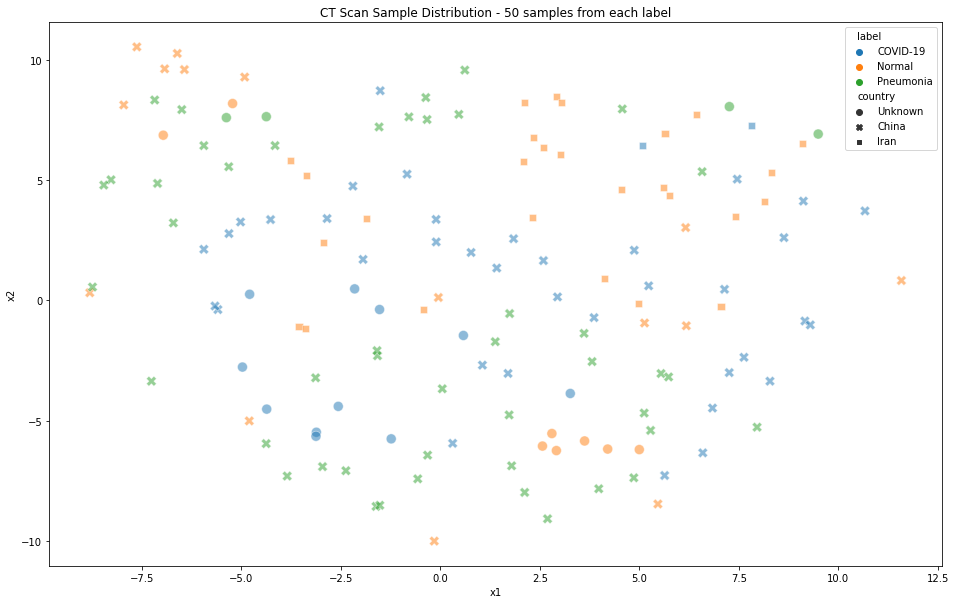

In [ ]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


df=pd.DataFrame(img_2d)
df["country"] = ct_label["country"]
df["label"] = ct_label["finding"]
df.loc[df["country"].isna(), "country"] = "Unknown"


covid_sample = df[df["label"]=="COVID-19"].sample(n=50)
normal_sample = df[df["label"]=="Normal"].sample(n=50)
pneu_sample = df[df["label"]=="Pneumonia"].sample(n=50)

sample=pd.concat([covid_sample, normal_sample, pneu_sample])
print(sample.shape)
# print(sample.columns)
country = sample["country"]
label=sample["label"]

sample.drop(columns=["country", "label"], inplace=True)

sample_pca = PCA(n_components=0.95).fit_transform(sample)
print(sample_pca.shape)

sample_tsne = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(sample_pca)
print(sample_tsne.shape)

sample_tsne = pd.DataFrame(sample_tsne, columns=["x1", "x2"])
print(sample_tsne.shape)
sample_tsne["country"] = country.tolist()
sample_tsne["label"] = label.tolist()
print(sample_tsne["label"].unique())

plt.figure(figsize=(16,10))
sns.scatterplot(
        x="x1", y="x2",
        hue="label",
        style="country",
        data=sample_tsne,
        s = 100,
        alpha=0.5
    )
plt.title("CT Scan Sample Distribution - 50 samples from each label")

In [ ]:
# country = sample["country"]
# label=sample["label"]
# sample.drop(columns=["country", "label"], inplace=True)
# sample.head()

print(sample_tsne.shape)
sample_tsne.head()
print(country)
print(label)

(150, 4)
466       China
335       China
266     Unknown
38        China
271       China
         ...   
1439      China
1279      China
1091      China
1302      China
1468      China
Name: country, Length: 150, dtype: object
466      COVID-19
335      COVID-19
266      COVID-19
38       COVID-19
271      COVID-19
          ...    
1439    Pneumonia
1279    Pneumonia
1091    Pneumonia
1302    Pneumonia
1468    Pneumonia
Name: label, Length: 150, dtype: object


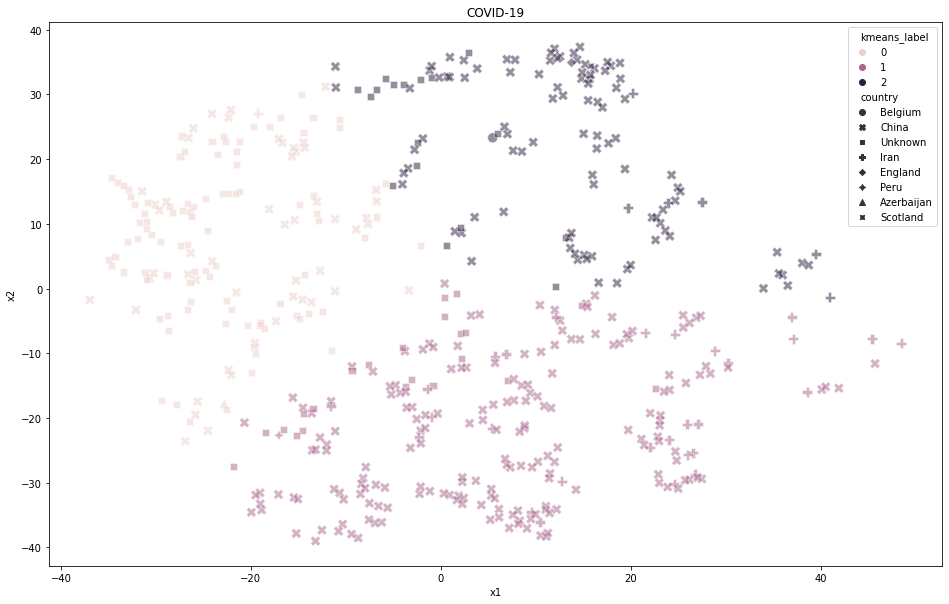

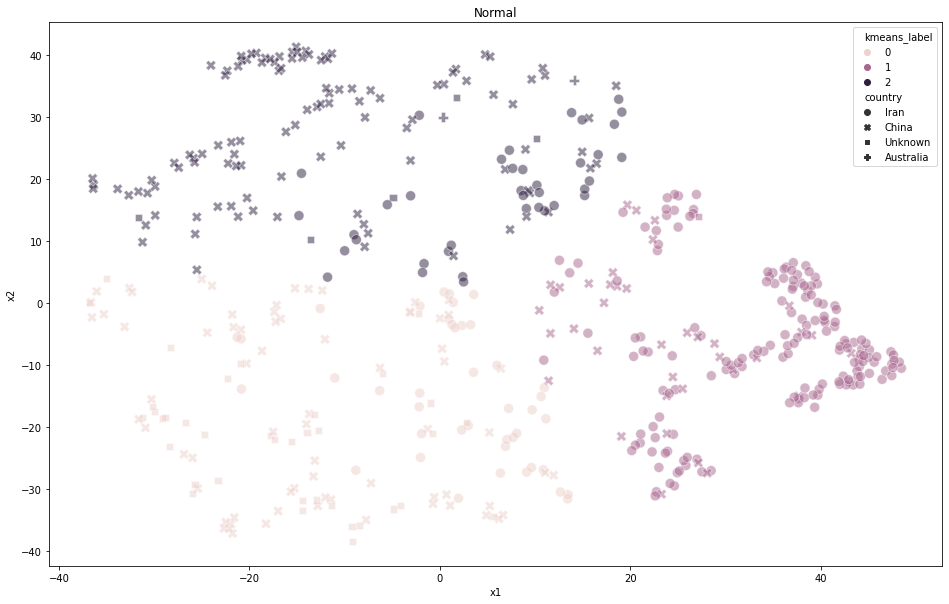

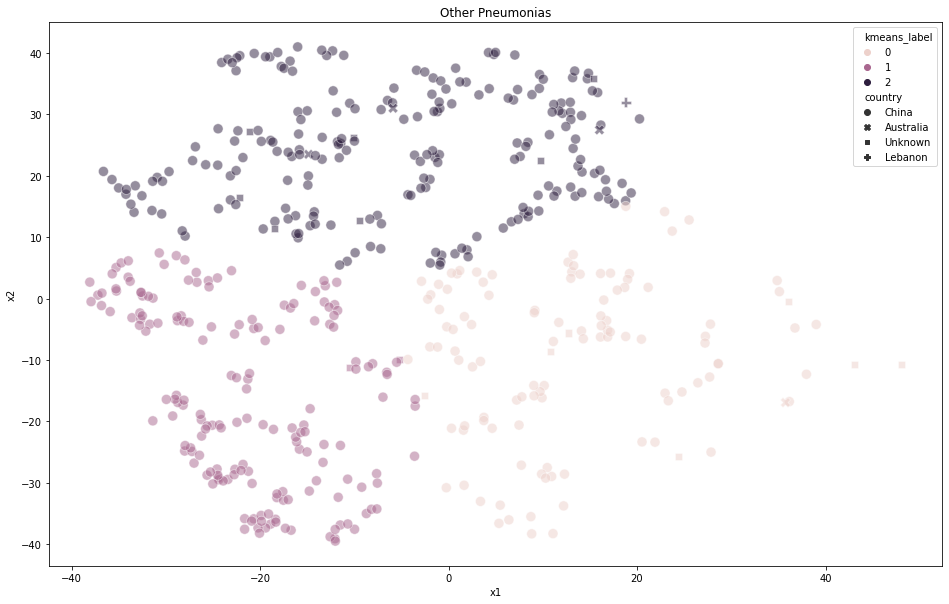

In [ ]:
from sklearn.cluster import KMeans
kmeans_covid = KMeans(n_clusters=3, random_state=42).fit(covid[["x1", "x2"]])
kmeans_normal = KMeans(n_clusters=3, random_state=42).fit(normal[["x1", "x2"]])
kmeans_pneu = KMeans(n_clusters=3, random_state=42).fit(pneu[["x1", "x2"]])
covid["kmeans_label"] = kmeans_covid.labels_
normal["kmeans_label"] = kmeans_normal.labels_
pneu["kmeans_label"] = kmeans_pneu.labels_

datasets = [covid, normal, pneu]
title = ["COVID-19", "Normal", "Other Pneumonias"]

for i in range(0, 3):
    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x="x1", y="x2",
        hue="kmeans_label",
        style="country",
        data=datasets[i],
        s = 100,
        alpha=0.5
    )
    plt.title(title[i])

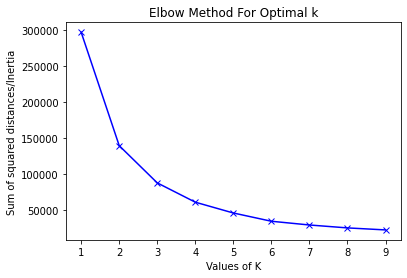

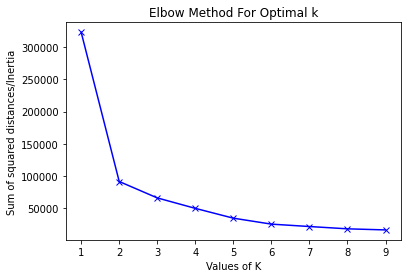

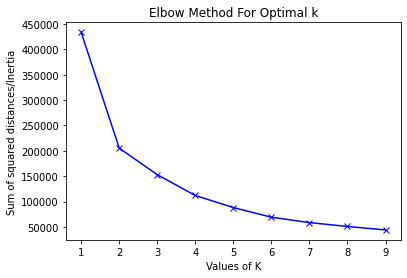

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import sklearn
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# K = range(1,10)
# Sum_of_squared_distances = []

# for num_clusters in K :
#     kmeans = KMeans(n_clusters=num_clusters)
#     kmeans.fit(covid[["x1", "x2"]])
#     Sum_of_squared_distances.append(kmeans.inertia_)
# plt.plot(K, Sum_of_squared_distances,"bx-")
# plt.xlabel("Values of K") 
# plt.ylabel("Sum of squared distances/Inertia") 
# plt.title("Elbow Method For Optimal k")
# plt.show()
# # optimal k=3 for covid

# Sum_of_squared_distances = []
# for num_clusters in K :
#     kmeans = KMeans(n_clusters=num_clusters)
#     kmeans.fit(normal[["x1", "x2"]])
#     Sum_of_squared_distances.append(kmeans.inertia_)
# plt.plot(K, Sum_of_squared_distances,"bx-")
# plt.xlabel("Values of K") 
# plt.ylabel("Sum of squared distances/Inertia") 
# plt.title("Elbow Method For Optimal k")
# plt.show()
# # optimal k=3 for normal


# Sum_of_squared_distances = []
# for num_clusters in K :
#     kmeans = KMeans(n_clusters=num_clusters)
#     kmeans.fit(pneu[["x1", "x2"]])
#     Sum_of_squared_distances.append(kmeans.inertia_)
# plt.plot(K, Sum_of_squared_distances,"bx-")
# plt.xlabel("Values of K") 
# plt.ylabel("Sum of squared distances/Inertia") 
# plt.title("Elbow Method For Optimal k")
# plt.show()
# # optimal k=2 for pneu

In [ ]:
print(pca.explained_variance_ratio_)

[0.13922098 0.11642592]


(1533, 224, 224)
(1533, 50176)
(150, 50178)
(150, 75)
(150, 2)
(150, 2)
['COVID-19' 'Normal' 'Pneumonia']


Text(0.5, 1.0, 'CXR Scan Sample Distribution - 50 samples from each label')

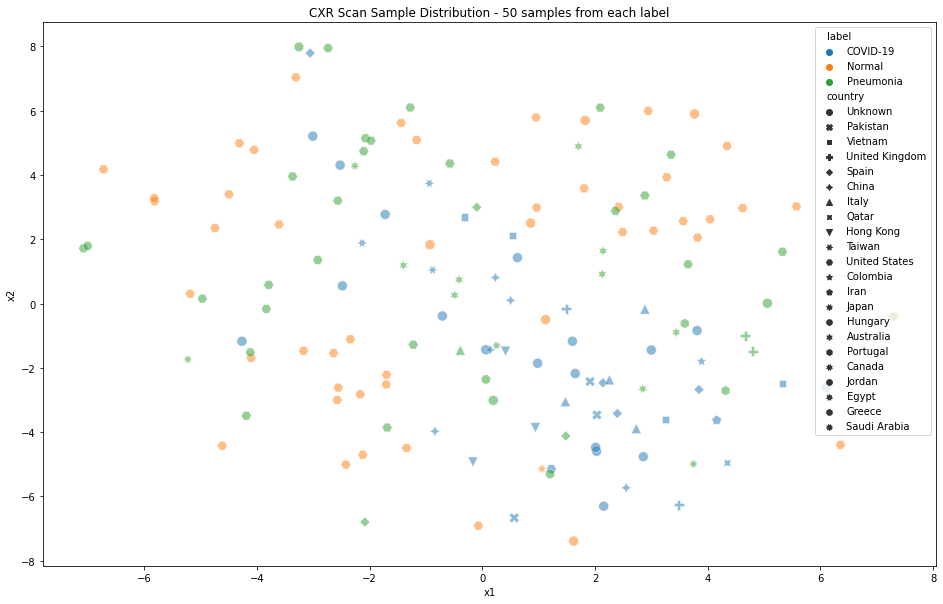

In [ ]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive 
# from google.colab import auth 
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

import numpy as np
import pandas as pd

# npz
file_id = '1-FfWliNgVmi7sHNUKoierGTpK2pMbYqW'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CXR_image.npz')
cxr_img = np.load(file='CXR_image.npz')

# csv
file_id = "1-K9DlBfH0GjS5Ous1KHJiSnGgH8ZlSPR"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CXR_label.csv')
cxr_label = pd.read_csv('CXR_label.csv')

cxr_label.loc[cxr_label["location"].isna(), "location"] = "Unknown"
cxr_label["location"] = [location.strip() for location in cxr_label["location"]]


img_3d = cxr_img["arr"]
print(img_3d.shape)
img_2d = img_3d.reshape(1533,224*224)
print(img_2d.shape)

df=pd.DataFrame(img_2d)
df["country"] = cxr_label["location"]
df["label"] = cxr_label["finding"]


covid_sample = df[df["label"]=="COVID-19"].sample(n=50)
normal_sample = df[df["label"]=="Normal"].sample(n=50)
pneu_sample = df[df["label"]=="Pneumonia"].sample(n=50)

sample=pd.concat([covid_sample, normal_sample, pneu_sample])
print(sample.shape)
# print(sample.columns)
country = sample["country"]
label=sample["label"]

sample.drop(columns=["country", "label"], inplace=True)

sample_pca = PCA(n_components=0.95).fit_transform(sample)
print(sample_pca.shape)

sample_tsne = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(sample_pca)
print(sample_tsne.shape)

sample_tsne = pd.DataFrame(sample_tsne, columns=["x1", "x2"])
print(sample_tsne.shape)
sample_tsne["country"] = country.tolist()
sample_tsne["label"] = label.tolist()
print(sample_tsne["label"].unique())

plt.figure(figsize=(16,10))
sns.scatterplot(
        x="x1", y="x2",
        hue="label",
        style="country",
        data=sample_tsne,
        s = 100,
        alpha=0.5
    )
plt.title("CXR Scan Sample Distribution - 50 samples from each label")


In [ ]:
cxr_label.loc[cxr_label["location"].isna(), "location"] = "Unknown"
location = cxr_label["location"]
cxr_label["location"] = [location.strip() for location in cxr_label["location"]]
cxr_label.head(100)

,Unnamed: 0,sex,age,finding,location,filename
0,0,M,65.0,COVID-19,Vietnam,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,1,M,65.0,COVID-19,Vietnam,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,2,M,65.0,COVID-19,Vietnam,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,3,M,65.0,COVID-19,Vietnam,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,4,F,52.0,COVID-19,Taiwan,nejmc2001573_f1a.jpeg
...,...,...,...,...,...,...
95,95,F,40.0,COVID-19,China,kjr-21-e25-g001-l-a.jpg
96,96,F,65.0,COVID-19,Italy,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg
97,97,M,NaN,COVID-19,Italy,353889E0-A1E8-4F9E-A0B8-F24F36BCFBFB.jpeg
98,98,M,33.0,COVID-19,Unknown,figure1-5e73d7ae897e27ff066a30cb-98.jpeg


(1533, 2)
(1533, 2)
          x1         x2  country      label
0 -17.541059 -32.334923  Vietnam   COVID-19
1 -22.295107 -30.695595  Vietnam   COVID-19
2 -27.142082 -26.207312  Vietnam   COVID-19
3 -16.228508 -25.758585  Vietnam   COVID-19
4  14.903304   7.126058   Taiwan   COVID-19
5  -9.235193  13.414784   Taiwan   COVID-19
6 -12.074647  -0.709529  Unknown  Pneumonia
7   9.919930 -22.736345    China   COVID-19
8  23.405025  -0.119981    China   COVID-19
9 -37.771549 -30.191652   Canada  Pneumonia


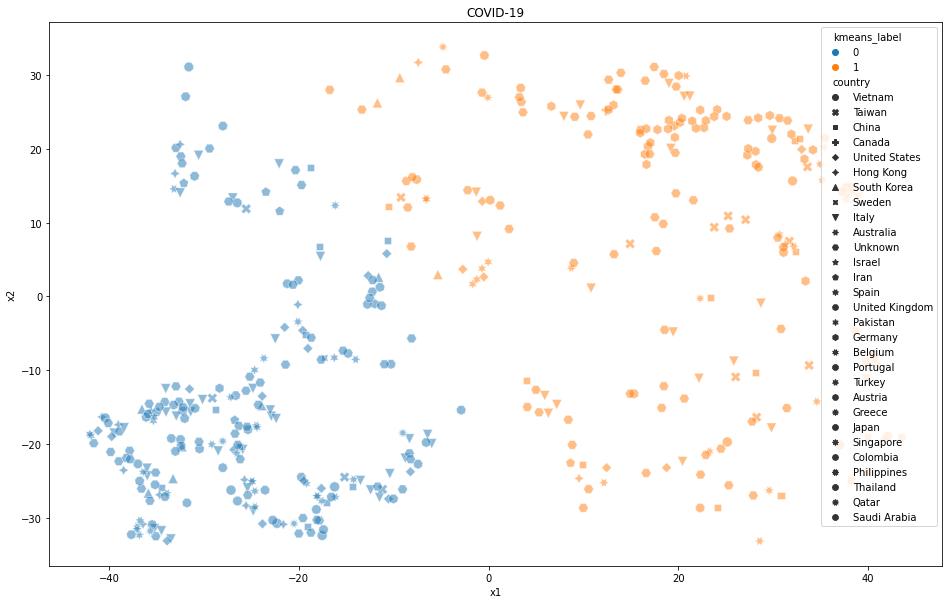

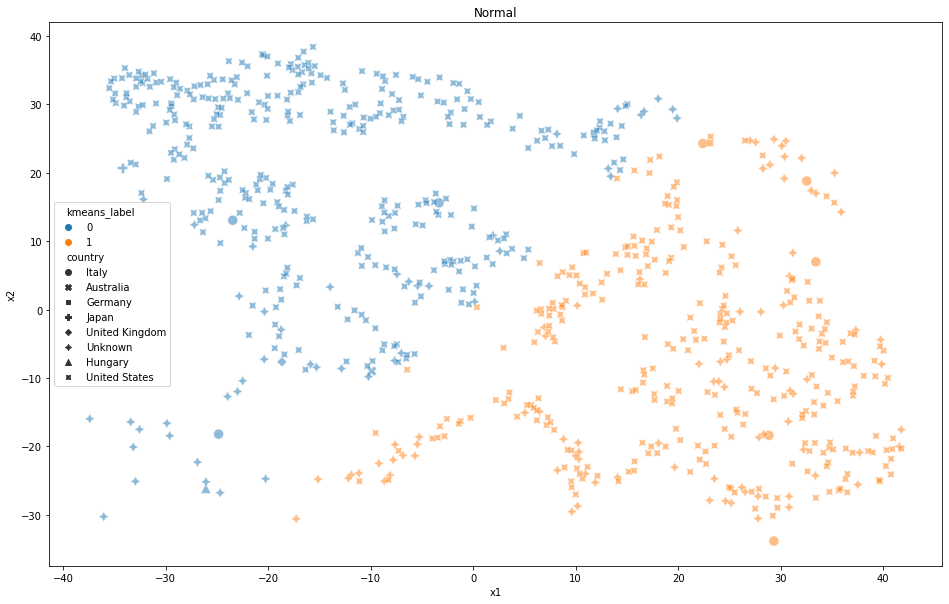

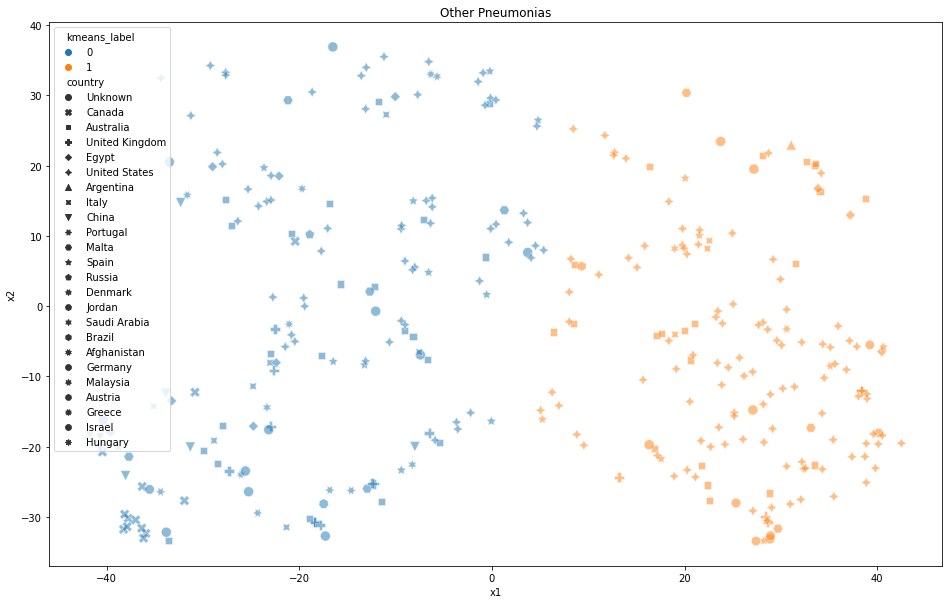

In [ ]:
from sklearn.cluster import KMeans

import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


Xpca = PCA(n_components=2).fit_transform(img_2d)
print(Xpca.shape)
# Xpca.head()

Xtsne = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(Xpca)
print(Xtsne.shape)

df = pd.DataFrame(Xtsne, columns=["x1", "x2"])
df["country"] = cxr_label["location"]
df["label"] = cxr_label["finding"]
# df.loc[df["country"].isna(), "country"] = "Unknown"
print(df.head(10))

covid = df[df["label"]=="COVID-19"]
covid.head()
normal = df[df["label"]=="Normal"]
normal.head()
pneu = df[df["label"]=="Pneumonia"]
pneu.head()

kmeans_covid = KMeans(n_clusters=2, random_state=42).fit(covid[["x1", "x2"]])
kmeans_normal = KMeans(n_clusters=2, random_state=42).fit(normal[["x1", "x2"]])
kmeans_pneu = KMeans(n_clusters=2, random_state=42).fit(pneu[["x1", "x2"]])
covid["kmeans_label"] = kmeans_covid.labels_
normal["kmeans_label"] = kmeans_normal.labels_
pneu["kmeans_label"] = kmeans_pneu.labels_

datasets = [covid, normal, pneu]
title = ["COVID-19", "Normal", "Other Pneumonias"]

for i in range(0, 3):
    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x="x1", y="x2",
        hue="kmeans_label",
        style="country",
        data=datasets[i],
        s = 100,
        alpha=0.5
    )
    plt.title(title[i])